In [1]:

import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [3]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [4]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [6]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_1HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '98.mat')
  X098_normal = scipy.io.loadmat(file_path1)['X098_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

 

  file_path2 = os.path.join(folder_path, '110.mat')
  X110_InnerRace_007  = scipy.io.loadmat(file_path2)['X110_DE_time']
  # mat_data = scipy.io.loadmat(file_path2)
  # print(mat_data.keys())

  file_path2 = os.path.join(folder_path, '123.mat')
  X123_Ball_007  = scipy.io.loadmat(file_path2)['X123_DE_time']

  file_path3 = os.path.join(folder_path, '136.mat')
  X136_Outer_007 = scipy.io.loadmat(file_path3)['X136_DE_time']

  file_path6 = os.path.join(folder_path, '175.mat')
  X175_InnerRace_014 = scipy.io.loadmat(file_path6)['X175_DE_time']
    
  file_path7 = os.path.join(folder_path, '190.mat')
  X190_Ball_014 = scipy.io.loadmat(file_path7)['X190_DE_time']

  file_path8 = os.path.join(folder_path, '202.mat')
  X202_Outer_014  = scipy.io.loadmat(file_path8)['X202_DE_time']
    
  file_path9 = os.path.join(folder_path, '214.mat')
  X214_InnerRace_021  = scipy.io.loadmat(file_path9)['X214_DE_time']

  file_path10 = os.path.join(folder_path, '227.mat')
  X227_Ball_021  = scipy.io.loadmat(file_path10)['X227_DE_time'] 

  file_path11 = os.path.join(folder_path, '239.mat')
  X239_Outer_021  = scipy.io.loadmat(file_path11)['X239_DE_time'] 
    
  return [X098_normal,X110_InnerRace_007,X123_Ball_007,X136_Outer_007,X175_InnerRace_014,X190_Ball_014,X202_Outer_014,X214_InnerRace_021,X227_Ball_021,X239_Outer_021]

In [7]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [8]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [9]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
interval_length = 1600 #320 #290 #200  
samples_per_block = 1600 #1600 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (483903, 1)
Dataset 2 shape: (486224, 1)
Dataset 3 shape: (487384, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (381890, 1)
Dataset 6 shape: (486224, 1)
Dataset 7 shape: (484483, 1)
Dataset 8 shape: (485063, 1)
Dataset 9 shape: (486804, 1)
Dataset 10 shape: (489125, 1)
[[ 0.046104   -0.03713354 -0.089496   ...  0.04714708 -0.00125169
  -0.07134646]
 [-0.14164985 -0.15792185 -0.10952308 ...  0.06133292 -0.00292062
  -0.03775938]
 [-0.01293415  0.05799508  0.111192   ... -0.13142769 -0.13267938
  -0.07802215]
 ...
 [ 0.47158667  0.38645067  0.30465333 ... -0.01418933 -0.06176533
  -0.07094667]
 [-0.055088   -0.020032    0.017528   ...  0.27544     0.35723733
   0.37226133]
 [ 0.33887467  0.247896    0.10934133 ... -0.11852267 -0.06426933
  -0.03422133]]
Shape of Input Data = (2954, 1600)
Shape of Label Y_CNN = (2954, 10)
Shape of Label Y = (2954, 1)


In [10]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,40,40,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(40,40,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(2954, 40, 40, 1)


In [11]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp5/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-10 08:25:09.658430: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1847 - loss: 2.0707
Epoch 1: val_accuracy improved from -inf to 0.43129, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1892 - loss: 2.0595 - val_accuracy: 0.4313 - val_loss: 1.3200
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5711 - loss: 1.0907
Epoch 2: val_accuracy improved from 0.43129 to 0.78647, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5745 - loss: 1.0828 - val_accuracy: 0.7865 - val_loss: 0.6218
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8049 - loss: 0.5202
Epoch 3: val_accuracy improved from 0.78647 to 0.83087, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8058 - loss: 0.5185 - val_accuracy: 0.8309 - val_loss: 0.4682
Epoch 4/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8476 - loss: 0.4399
Epoch 4: val_accuracy improved from 0.83087 to 0.83510, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8486 - loss: 0.4387 - val_accuracy: 0.8351 - val_loss: 0.4244
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8997 - loss: 0.2781
Epoch 5: val_accuracy did not improve from 0.83510
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9001 - loss: 0.2771 - val_accuracy: 0.8224 - val_loss: 0.4700
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8860 - loss: 0.3192
Epoch 6: val_accuracy improved from 0.83510 to 0.83721, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8866 - loss: 0.3174 - val_accuracy: 0.8372 - val_loss: 0.4410
Epoch 7/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8968 - loss: 0.2795
Epoch 7: val_accuracy did not improve from 0.83721
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8974 - loss: 0.2781 - val_accuracy: 0.8182 - val_loss: 0.4990
Epoch 8/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9195 - loss: 0.2269
Epoch 8: val_accuracy improved from 0.83721 to 0.92812, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9201 - loss: 0.2250 - val_accuracy: 0.9281 - val_loss: 0.1963
Epoch 9/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9518 - loss: 0.1373
Epoch 9: val_accuracy did not improve from 0.92812
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9519 - loss: 0.1369 - val_accuracy: 0.8414 - val_loss: 0.5118
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9394 - loss: 0.1947
Epoch 10: val_accuracy improved from 0.92812 to 0.93869, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9396 - loss: 0.1938 - val_accuracy: 0.9387 - val_loss: 0.1568
Epoch 11/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9524 - loss: 0.1159
Epoch 11: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9524 - loss: 0.1162 - val_accuracy: 0.7569 - val_loss: 0.7825
Epoch 12/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9198 - loss: 0.2588
Epoch 12: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9206 - loss: 0.2561 - val_accuracy: 0.7992 - val_loss: 0.5871
Epoch 13/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9190 - loss: 0.2335
Epoch 13: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9201 - loss: 0.2300 - val_accuracy: 0.8985 - val_loss: 0.2962
Epoch 14/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9508 - loss: 0.1292
Epoch 14: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9757 - loss: 0.0753 - val_accuracy: 0.9598 - val_loss: 0.1246
Epoch 16/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9792 - loss: 0.0571
Epoch 16: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9791 - loss: 0.0572 - val_accuracy: 0.9450 - val_loss: 0.2029
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9820 - loss: 0.0507
Epoch 17: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9514 - val_loss: 0.1289
Epoch 18/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9880 - loss: 0.0359
Epoch 18: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9878 - loss: 0.0361 - val_accuracy: 0.9302 - val_loss: 0.2119
Epoch 19/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9800 - loss: 0.0543
Epoch 19: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9880 - loss: 0.0383 - val_accuracy: 0.9641 - val_loss: 0.1235
Epoch 22/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9890 - loss: 0.0328
Epoch 22: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9887 - loss: 0.0331 - val_accuracy: 0.9408 - val_loss: 0.1740
Epoch 23/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9779 - loss: 0.0661
Epoch 23: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9778 - loss: 0.0662 - val_accuracy: 0.9323 - val_loss: 0.2078
Epoch 24/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9741 - loss: 0.0668
Epoch 24: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9739 - loss: 0.0673 - val_accuracy: 0.9175 - val_loss: 0.2690
Epoch 25/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9934 - loss: 0.0331
Epoch 25: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9934 - loss: 0.0327 - val_accuracy: 0.9683 - val_loss: 0.0959
Epoch 26/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9941 - loss: 0.0174
Epoch 26: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9941 - loss: 0.0176 - val_accuracy: 0.9493 - val_loss: 0.1847
Epoch 27/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9840 - loss: 0.0369
Epoch 27: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9839 - loss: 0.0370 - val_accuracy: 0.9471 - val_loss: 0.1732
Epoch 28/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9844 - loss: 0.0361
Epoch 28: val_accuracy improved from 0.96829 to 0.97463, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9844 - loss: 0.0359 - val_accuracy: 0.9746 - val_loss: 0.1103
Epoch 29/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9923 - loss: 0.0164
Epoch 29: val_accuracy did not improve from 0.97463
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9922 - loss: 0.0165 - val_accuracy: 0.8414 - val_loss: 0.5167
Epoch 30/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9649 - loss: 0.0984
Epoch 30: val_accuracy did not improve from 0.97463
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9649 - loss: 0.0981 - val_accuracy: 0.9260 - val_loss: 0.2598
Epoch 31/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9788 - loss: 0.0925
Epoch 31: val_accuracy did not improve from 0.97463
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9789 - loss: 0.0916 - val_accuracy: 0.9641 - val_loss: 0.1477
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9896 - loss: 0.0225
Epoch 32: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9896 - loss: 0.0225 - val_accuracy: 0.9767 - val_loss: 0.0923
Epoch 33/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9846 - loss: 0.0382
Epoch 33: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9847 - loss: 0.0382 - val_accuracy: 0.9619 - val_loss: 0.1157
Epoch 34/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9938 - loss: 0.0179
Epoch 34: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9938 - loss: 0.0180 - val_accuracy: 0.9408 - val_loss: 0.1962
Epoch 35/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9935 - loss: 0.0180
Epoch 35: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9936 - loss: 0.0179 - val_accuracy: 0.9704 - val_loss: 0.1083
Epoch 36/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9986 - loss: 0.0059
Epoch 36: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 1.0000 - loss: 1.5856e-04 - val_accuracy: 0.9789 - val_loss: 0.1101
Epoch 66/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 1.1367e-04
Epoch 66: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 1.0000 - loss: 1.1369e-04 - val_accuracy: 0.9789 - val_loss: 0.1086
Epoch 67/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 9.4967e-05
Epoch 67: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 9.5085e-05 - val_accuracy: 0.9789 - val_loss: 0.1092
Epoch 68/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 8.7803e-05
Epoch 68: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 1.0000 - loss: 8.7858e-05 - val_accuracy: 0.9789 - val_loss: 0.1097
Epoch 69/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 8.1393e-05


Best model saved at: CNN2D_results/V4_2_NOL_exp5/best_model_1.h5
Best model loaded successfully!


2025-06-10 08:31:26.999076: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:31:27.000415: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.0885e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9815 - loss: 0.0717
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9877 - loss: 0.0499
Epoch 1/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1719 - loss: 2.0568

2025-06-10 08:31:34.442518: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:31:34.442853: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.67019, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1762 - loss: 2.0509 - val_accuracy: 0.6702 - val_loss: 1.3473
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6321 - loss: 1.1751
Epoch 2: val_accuracy improved from 0.67019 to 0.75053, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6330 - loss: 1.1697 - val_accuracy: 0.7505 - val_loss: 0.6190
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7534 - loss: 0.6297
Epoch 3: val_accuracy improved from 0.75053 to 0.78858, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7536 - loss: 0.6297 - val_accuracy: 0.7886 - val_loss: 0.5209
Epoch 4/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7550 - loss: 0.6212
Epoch 4: val_accuracy improved from 0.78858 to 0.79070, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7551 - loss: 0.6219 - val_accuracy: 0.7907 - val_loss: 0.4885
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8405 - loss: 0.4194
Epoch 5: val_accuracy improved from 0.79070 to 0.83510, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8404 - loss: 0.4196 - val_accuracy: 0.8351 - val_loss: 0.4041
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8993 - loss: 0.2886
Epoch 6: val_accuracy improved from 0.83510 to 0.85624, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8990 - loss: 0.2892 - val_accuracy: 0.8562 - val_loss: 0.3191
Epoch 7/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9286 - loss: 0.2198
Epoch 7: val_accuracy improved from 0.85624 to 0.87315, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9279 - loss: 0.2216 - val_accuracy: 0.8732 - val_loss: 0.3324
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9200 - loss: 0.2345
Epoch 8: val_accuracy did not improve from 0.87315
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9198 - loss: 0.2349 - val_accuracy: 0.8668 - val_loss: 0.3514
Epoch 9/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9371 - loss: 0.1847
Epoch 9: val_accuracy improved from 0.87315 to 0.89852, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9368 - loss: 0.1851 - val_accuracy: 0.8985 - val_loss: 0.2653
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9453 - loss: 0.1563
Epoch 10: val_accuracy did not improve from 0.89852
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9453 - loss: 0.1563 - val_accuracy: 0.8689 - val_loss: 0.2865
Epoch 11/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9516 - loss: 0.1389
Epoch 11: val_accuracy improved from 0.89852 to 0.91121, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9513 - loss: 0.1393 - val_accuracy: 0.9112 - val_loss: 0.2059
Epoch 12/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9548 - loss: 0.1288
Epoch 12: val_accuracy improved from 0.91121 to 0.94292, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9547 - loss: 0.1286 - val_accuracy: 0.9429 - val_loss: 0.1385
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9636 - loss: 0.0943
Epoch 13: val_accuracy did not improve from 0.94292
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9635 - loss: 0.0945 - val_accuracy: 0.9091 - val_loss: 0.2238
Epoch 14/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9587 - loss: 0.1031
Epoch 14: val_accuracy did not improve from 0.94292
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9587 - loss: 0.1030 - val_accuracy: 0.9070 - val_loss: 0.2496
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9496 - loss: 0.1229
Epoch 15: val_accuracy did not improve from 0.94292
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9497 - loss: 0.1227 - val_accuracy: 0.9239 - val_loss: 0.1906
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9697 - loss: 0.0828
Epoch 16: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9696 - loss: 0.0828 - val_accuracy: 0.9598 - val_loss: 0.1096
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9784 - loss: 0.0560
Epoch 17: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9784 - loss: 0.0561 - val_accuracy: 0.9598 - val_loss: 0.1097
Epoch 18/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9801 - loss: 0.0511
Epoch 18: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9800 - loss: 0.0512 - val_accuracy: 0.9471 - val_loss: 0.1192
Epoch 19/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9826 - loss: 0.0433
Epoch 19: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9826 - loss: 0.0436 - val_accuracy: 0.9429 - val_loss: 0.1792
Epoch 20/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9529 - loss: 0.1195
Epoch 20: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9840 - loss: 0.0460 - val_accuracy: 0.9683 - val_loss: 0.1020
Epoch 25/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9912 - loss: 0.0266
Epoch 25: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9911 - loss: 0.0268 - val_accuracy: 0.9662 - val_loss: 0.0975
Epoch 26/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9944 - loss: 0.0197
Epoch 26: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9943 - loss: 0.0200 - val_accuracy: 0.9493 - val_loss: 0.1548
Epoch 27/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9888 - loss: 0.0281
Epoch 27: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9888 - loss: 0.0281 - val_accuracy: 0.9598 - val_loss: 0.1277
Epoch 28/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9889 - loss: 0.0216
Epoch 28: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9768 - loss: 0.0523 - val_accuracy: 0.9704 - val_loss: 0.1040
Epoch 36/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9843 - loss: 0.0840
Epoch 36: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9821 - loss: 0.0948 - val_accuracy: 0.8943 - val_loss: 0.3304
Epoch 37/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9379 - loss: 0.2273
Epoch 37: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9388 - loss: 0.2245 - val_accuracy: 0.9387 - val_loss: 0.1541
Epoch 38/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9771 - loss: 0.0602
Epoch 38: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9771 - loss: 0.0602 - val_accuracy: 0.9641 - val_loss: 0.1135
Epoch 39/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9965 - loss: 0.0238
Epoch 39: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 1.0000 - loss: 9.7957e-04 - val_accuracy: 0.9725 - val_loss: 0.1007
Epoch 50/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9967 - loss: 0.0109
Epoch 50: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9967 - loss: 0.0111 - val_accuracy: 0.9619 - val_loss: 0.1621
Epoch 51/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9855 - loss: 0.0379
Epoch 51: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9856 - loss: 0.0377 - val_accuracy: 0.9662 - val_loss: 0.1140
Epoch 52/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 52: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9683 - val_loss: 0.0716
Epoch 53/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 53: val_accuracy impro

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9767 - val_loss: 0.0701
Epoch 54/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 7.5181e-04
Epoch 54: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 7.7116e-04 - val_accuracy: 0.9767 - val_loss: 0.0701
Epoch 55/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 55: val_accuracy improved from 0.97674 to 0.98097, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9810 - val_loss: 0.0740
Epoch 56/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 5.2408e-04
Epoch 56: val_accuracy did not improve from 0.98097
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 5.2974e-04 - val_accuracy: 0.9789 - val_loss: 0.0669
Epoch 57/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 8.7848e-04
Epoch 57: val_accuracy did not improve from 0.98097
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 8.7857e-04 - val_accuracy: 0.9810 - val_loss: 0.0821
Epoch 58/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 5.2622e-04
Epoch 58: val_accuracy did not improve from 0.98097
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 5.2838e-04 - val_accuracy: 0.9810 - val_loss: 0.0868
Epoch 59/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.6820e-04
Epoc

Best model saved at: CNN2D_results/V4_2_NOL_exp5/best_model_2.h5
Best model loaded successfully!


2025-06-10 08:36:53.263704: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:36:53.264057: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 4.3150e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9855 - loss: 0.0481
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9908 - loss: 0.0398
Epoch 1/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1870 - loss: 2.0449

2025-06-10 08:37:00.199799: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:37:00.200164: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.50106, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1912 - loss: 2.0366 - val_accuracy: 0.5011 - val_loss: 1.4231
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5999 - loss: 1.1426
Epoch 2: val_accuracy improved from 0.50106 to 0.81395, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6035 - loss: 1.1324 - val_accuracy: 0.8140 - val_loss: 0.4984
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8602 - loss: 0.3695
Epoch 3: val_accuracy improved from 0.81395 to 0.86892, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8605 - loss: 0.3692 - val_accuracy: 0.8689 - val_loss: 0.4188
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8804 - loss: 0.3296
Epoch 4: val_accuracy did not improve from 0.86892
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8802 - loss: 0.3300 - val_accuracy: 0.8266 - val_loss: 0.5324
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8879 - loss: 0.3188
Epoch 5: val_accuracy did not improve from 0.86892
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8878 - loss: 0.3187 - val_accuracy: 0.8520 - val_loss: 0.4431
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9073 - loss: 0.2444
Epoch 6: val_accuracy did not improve from 0.86892
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9072 - loss: 0.2446 - val_accuracy: 0.8689 - val_loss: 0.4323
Epoch 7/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9264 - loss: 0.2071
Epoch 7: val_accuracy improved from 0.8

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9263 - loss: 0.2077 - val_accuracy: 0.8964 - val_loss: 0.3030
Epoch 8/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9224 - loss: 0.1836
Epoch 8: val_accuracy improved from 0.89641 to 0.92389, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9225 - loss: 0.1840 - val_accuracy: 0.9239 - val_loss: 0.2696
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9422 - loss: 0.1482
Epoch 9: val_accuracy did not improve from 0.92389
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9421 - loss: 0.1486 - val_accuracy: 0.8964 - val_loss: 0.3196
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9524 - loss: 0.1353
Epoch 10: val_accuracy improved from 0.92389 to 0.93023, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9524 - loss: 0.1353 - val_accuracy: 0.9302 - val_loss: 0.2871
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9680 - loss: 0.0909
Epoch 11: val_accuracy did not improve from 0.93023
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9679 - loss: 0.0911 - val_accuracy: 0.9133 - val_loss: 0.2544
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9686 - loss: 0.0873
Epoch 12: val_accuracy did not improve from 0.93023
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9685 - loss: 0.0877 - val_accuracy: 0.9154 - val_loss: 0.2964
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9669 - loss: 0.1219
Epoch 13: val_accuracy did not improve from 0.93023
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9669 - loss: 0.1216 - val_accuracy: 0.8837 - val_loss: 0.2960
Epoch 14/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9447 - loss: 0.1595
Epoch 14: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9635 - loss: 0.0913 - val_accuracy: 0.9345 - val_loss: 0.1997
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9723 - loss: 0.0684
Epoch 16: val_accuracy did not improve from 0.93446
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9725 - loss: 0.0682 - val_accuracy: 0.9260 - val_loss: 0.2229
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9687 - loss: 0.0717
Epoch 17: val_accuracy did not improve from 0.93446
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9689 - loss: 0.0714 - val_accuracy: 0.9239 - val_loss: 0.2435
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9765 - loss: 0.0624
Epoch 18: val_accuracy did not improve from 0.93446
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9767 - loss: 0.0621 - val_accuracy: 0.9323 - val_loss: 0.2499
Epoch 19/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9768 - loss: 0.0551
Epoch 19: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9731 - loss: 0.0648 - val_accuracy: 0.9450 - val_loss: 0.1787
Epoch 23/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9635 - loss: 0.0918
Epoch 23: val_accuracy did not improve from 0.94503
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9636 - loss: 0.0918 - val_accuracy: 0.9260 - val_loss: 0.2249
Epoch 24/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9667 - loss: 0.0695
Epoch 24: val_accuracy improved from 0.94503 to 0.96195, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9667 - loss: 0.0697 - val_accuracy: 0.9619 - val_loss: 0.1443
Epoch 25/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9865 - loss: 0.0455
Epoch 25: val_accuracy improved from 0.96195 to 0.97674, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9866 - loss: 0.0451 - val_accuracy: 0.9767 - val_loss: 0.1259
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9990 - loss: 0.0102
Epoch 26: val_accuracy improved from 0.97674 to 0.97886, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9990 - loss: 0.0102 - val_accuracy: 0.9789 - val_loss: 0.0858
Epoch 27/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9989 - loss: 0.0054
Epoch 27: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.9789 - val_loss: 0.0972
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9995 - loss: 0.0036
Epoch 28: val_accuracy improved from 0.97886 to 0.98097, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.9810 - val_loss: 0.0747
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 29: val_accuracy improved from 0.98097 to 0.98309, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9831 - val_loss: 0.0756
Epoch 30/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 30: val_accuracy improved from 0.98309 to 0.98520, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9852 - val_loss: 0.0767
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 31: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9852 - val_loss: 0.0753
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 8.2328e-04
Epoch 32: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 8.2660e-04 - val_accuracy: 0.9852 - val_loss: 0.0779
Epoch 33/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 6.5536e-04
Epoch 33: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 1.0000 - loss: 6.5730e-04 - val_accuracy: 0.9852 - val_loss: 0.0812
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 5.4786e-04
Epoch 34: va

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 1.0000 - loss: 3.1861e-04 - val_accuracy: 0.9873 - val_loss: 0.0852
Epoch 38/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 2.7835e-04
Epoch 38: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 2.7911e-04 - val_accuracy: 0.9873 - val_loss: 0.0859
Epoch 39/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 2.4474e-04
Epoch 39: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 - loss: 2.4578e-04 - val_accuracy: 0.9852 - val_loss: 0.0863
Epoch 40/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 2.2075e-04
Epoch 40: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 2.2165e-04 - val_accuracy: 0.9852 - val_loss: 0.0870
Epoch 41/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 1.9774e-04


Best model saved at: CNN2D_results/V4_2_NOL_exp5/best_model_3.h5
Best model loaded successfully!


2025-06-10 08:41:17.163869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:41:17.164228: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.4972e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9880 - loss: 0.0618
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9949 - loss: 0.0197
Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1937 - loss: 1.9773

2025-06-10 08:41:23.592608: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:41:23.592966: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.54025, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.1957 - loss: 1.9731 - val_accuracy: 0.5403 - val_loss: 1.1183
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6264 - loss: 0.9812
Epoch 2: val_accuracy improved from 0.54025 to 0.71610, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6281 - loss: 0.9771 - val_accuracy: 0.7161 - val_loss: 0.6318
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7826 - loss: 0.5850
Epoch 3: val_accuracy improved from 0.71610 to 0.81780, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7835 - loss: 0.5833 - val_accuracy: 0.8178 - val_loss: 0.4339
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8553 - loss: 0.3958
Epoch 4: val_accuracy improved from 0.81780 to 0.83263, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8554 - loss: 0.3954 - val_accuracy: 0.8326 - val_loss: 0.4524
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8616 - loss: 0.3731
Epoch 5: val_accuracy improved from 0.83263 to 0.86017, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8617 - loss: 0.3725 - val_accuracy: 0.8602 - val_loss: 0.3307
Epoch 6/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8896 - loss: 0.2791
Epoch 6: val_accuracy improved from 0.86017 to 0.87924, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8897 - loss: 0.2800 - val_accuracy: 0.8792 - val_loss: 0.3541
Epoch 7/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9059 - loss: 0.2961
Epoch 7: val_accuracy improved from 0.87924 to 0.90678, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9061 - loss: 0.2947 - val_accuracy: 0.9068 - val_loss: 0.2515
Epoch 8/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9232 - loss: 0.1959
Epoch 8: val_accuracy improved from 0.90678 to 0.92373, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9234 - loss: 0.1956 - val_accuracy: 0.9237 - val_loss: 0.2296
Epoch 9/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9438 - loss: 0.1426
Epoch 9: val_accuracy improved from 0.92373 to 0.94280, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9438 - loss: 0.1427 - val_accuracy: 0.9428 - val_loss: 0.1840
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9625 - loss: 0.1017
Epoch 10: val_accuracy did not improve from 0.94280
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9624 - loss: 0.1018 - val_accuracy: 0.8962 - val_loss: 0.2647
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9369 - loss: 0.1632
Epoch 11: val_accuracy improved from 0.94280 to 0.94492, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9369 - loss: 0.1631 - val_accuracy: 0.9449 - val_loss: 0.1481
Epoch 12/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9709 - loss: 0.0846
Epoch 12: val_accuracy improved from 0.94492 to 0.96186, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9709 - loss: 0.0845 - val_accuracy: 0.9619 - val_loss: 0.1129
Epoch 13/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9794 - loss: 0.0624
Epoch 13: val_accuracy improved from 0.96186 to 0.97881, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9793 - loss: 0.0623 - val_accuracy: 0.9788 - val_loss: 0.0525
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9886 - loss: 0.0350
Epoch 14: val_accuracy did not improve from 0.97881
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9886 - loss: 0.0350 - val_accuracy: 0.9725 - val_loss: 0.0750
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9899 - loss: 0.0321
Epoch 15: val_accuracy did not improve from 0.97881
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9897 - loss: 0.0326 - val_accuracy: 0.9492 - val_loss: 0.1751
Epoch 16/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9781 - loss: 0.0615
Epoch 16: val_accuracy did not improve from 0.97881
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9782 - loss: 0.0612 - val_accuracy: 0.9725 - val_loss: 0.0851
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9880 - loss: 0.0310
Epoch 17: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9877 - loss: 0.0317 - val_accuracy: 0.9831 - val_loss: 0.0584
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9895 - loss: 0.0342
Epoch 18: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.8898 - val_loss: 0.2998
Epoch 19/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9737 - loss: 0.0693
Epoch 19: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9739 - loss: 0.0689 - val_accuracy: 0.9809 - val_loss: 0.0879
Epoch 20/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9853 - loss: 0.0394
Epoch 20: val_accuracy did not improve from 0.98305
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9855 - loss: 0.0392 - val_accuracy: 0.9809 - val_loss: 0.0477
Epoch 21/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9886 - loss: 0.0320
Epoch 21: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9969 - loss: 0.0192 - val_accuracy: 0.9894 - val_loss: 0.0240
Epoch 30/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9973 - loss: 0.0086
Epoch 30: val_accuracy did not improve from 0.98941
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9973 - loss: 0.0088 - val_accuracy: 0.9852 - val_loss: 0.0799
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9763 - loss: 0.0504
Epoch 31: val_accuracy improved from 0.98941 to 0.99153, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9764 - loss: 0.0503 - val_accuracy: 0.9915 - val_loss: 0.0292
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9907 - loss: 0.0244
Epoch 32: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9906 - loss: 0.0248 - val_accuracy: 0.9746 - val_loss: 0.0941
Epoch 33/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9932 - loss: 0.0215
Epoch 33: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9931 - loss: 0.0215 - val_accuracy: 0.9852 - val_loss: 0.0378
Epoch 34/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9996 - loss: 0.0051
Epoch 34: val_accuracy did not improve from 0.99153
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.9915 - val_loss: 0.0274
Epoch 35/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 35: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9936 - val_loss: 0.0229
Epoch 36/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 8.0972e-04
Epoch 36: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 8.0726e-04 - val_accuracy: 0.9936 - val_loss: 0.0233
Epoch 37/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 6.5393e-04
Epoch 37: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 6.5183e-04 - val_accuracy: 0.9936 - val_loss: 0.0232
Epoch 38/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 4.9197e-04
Epoch 38: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 1.0000 - loss: 4.9163e-04 - val_accuracy: 0.9936 - val_loss: 0.0241
Epoch 39/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 4.0534e-04
Epoc

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.0000 - loss: 2.1726e-05 - val_accuracy: 0.9958 - val_loss: 0.0382
Epoch 70/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 2.0071e-05
Epoch 70: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 2.0138e-05 - val_accuracy: 0.9958 - val_loss: 0.0386
Epoch 71/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 1.8667e-05
Epoch 71: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 1.0000 - loss: 1.8697e-05 - val_accuracy: 0.9958 - val_loss: 0.0389
Epoch 72/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 1.7336e-05
Epoch 72: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 1.7388e-05 - val_accuracy: 0.9958 - val_loss: 0.0390
Epoch 73/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 1.5983e-05


Best model saved at: CNN2D_results/V4_2_NOL_exp5/best_model_4.h5
Best model loaded successfully!


2025-06-10 08:47:46.953961: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:47:46.955557: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 1.6266e-05
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9912 - loss: 0.0656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9925 - loss: 0.0236
Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1972 - loss: 1.9979

2025-06-10 08:47:53.464576: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:47:53.464906: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.55932, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1991 - loss: 1.9941 - val_accuracy: 0.5593 - val_loss: 1.1056
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6512 - loss: 0.9930
Epoch 2: val_accuracy improved from 0.55932 to 0.76695, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6521 - loss: 0.9901 - val_accuracy: 0.7669 - val_loss: 0.5543
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7874 - loss: 0.5616
Epoch 3: val_accuracy improved from 0.76695 to 0.81992, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7884 - loss: 0.5593 - val_accuracy: 0.8199 - val_loss: 0.4897
Epoch 4/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8698 - loss: 0.3564
Epoch 4: val_accuracy improved from 0.81992 to 0.87924, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8700 - loss: 0.3560 - val_accuracy: 0.8792 - val_loss: 0.3868
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8245 - loss: 0.4473
Epoch 5: val_accuracy improved from 0.87924 to 0.91314, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8251 - loss: 0.4460 - val_accuracy: 0.9131 - val_loss: 0.2585
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9089 - loss: 0.2459
Epoch 6: val_accuracy did not improve from 0.91314
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9090 - loss: 0.2458 - val_accuracy: 0.8411 - val_loss: 0.4102
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9259 - loss: 0.2372
Epoch 7: val_accuracy did not improve from 0.91314
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9260 - loss: 0.2368 - val_accuracy: 0.8835 - val_loss: 0.3076
Epoch 8/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9177 - loss: 0.2235
Epoch 8: val_accuracy improved from 0.91314 to 0.91949, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9179 - loss: 0.2231 - val_accuracy: 0.9195 - val_loss: 0.3000
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9410 - loss: 0.1836
Epoch 9: val_accuracy improved from 0.91949 to 0.94068, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9411 - loss: 0.1831 - val_accuracy: 0.9407 - val_loss: 0.1962
Epoch 10/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9519 - loss: 0.1262
Epoch 10: val_accuracy improved from 0.94068 to 0.96610, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9522 - loss: 0.1254 - val_accuracy: 0.9661 - val_loss: 0.1335
Epoch 11/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9748 - loss: 0.0760
Epoch 11: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9746 - loss: 0.0761 - val_accuracy: 0.9576 - val_loss: 0.1317
Epoch 12/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9792 - loss: 0.0645
Epoch 12: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9788 - loss: 0.0654 - val_accuracy: 0.9534 - val_loss: 0.1604
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9784 - loss: 0.0646
Epoch 13: val_accuracy did not improve from 0.96610
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9783 - loss: 0.0650 - val_accuracy: 0.8242 - val_loss: 0.5934
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9520 - loss: 0.1178
Epoch 14: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9523 - loss: 0.1173 - val_accuracy: 0.9746 - val_loss: 0.0760
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9597 - loss: 0.0922
Epoch 15: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9599 - loss: 0.0925 - val_accuracy: 0.9534 - val_loss: 0.1862
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9557 - loss: 0.1226
Epoch 16: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9559 - loss: 0.1221 - val_accuracy: 0.9640 - val_loss: 0.1315
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9703 - loss: 0.0853
Epoch 17: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9703 - loss: 0.0849 - val_accuracy: 0.9746 - val_loss: 0.1036
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9873 - loss: 0.0410
Epoch 18: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9852 - loss: 0.0424 - val_accuracy: 0.9852 - val_loss: 0.0534
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9896 - loss: 0.0244
Epoch 24: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9896 - loss: 0.0244 - val_accuracy: 0.9831 - val_loss: 0.0768
Epoch 25/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9948 - loss: 0.0167
Epoch 25: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9949 - loss: 0.0166 - val_accuracy: 0.9831 - val_loss: 0.0693
Epoch 26/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9913 - loss: 0.0236
Epoch 26: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9913 - loss: 0.0235 - val_accuracy: 0.9788 - val_loss: 0.0636
Epoch 27/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9758 - loss: 0.0555
Epoch 27: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9808 - loss: 0.0580 - val_accuracy: 0.9873 - val_loss: 0.0380
Epoch 36/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 36: val_accuracy did not improve from 0.98729
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9788 - val_loss: 0.0508
Epoch 37/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9995 - loss: 0.0065
Epoch 37: val_accuracy improved from 0.98729 to 0.99364, saving model to CNN2D_results/V4_2_NOL_exp5/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9994 - loss: 0.0066 - val_accuracy: 0.9936 - val_loss: 0.0224
Epoch 38/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9834 - loss: 0.0421
Epoch 38: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9836 - loss: 0.0415 - val_accuracy: 0.9809 - val_loss: 0.0576
Epoch 39/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9946 - loss: 0.0123
Epoch 39: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9947 - loss: 0.0122 - val_accuracy: 0.9809 - val_loss: 0.0607
Epoch 40/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9964 - loss: 0.0104
Epoch 40: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 0.9809 - val_loss: 0.0655
Epoch 41/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9984 - loss: 0.0050
Epoch 41: val_accuracy did not 

Best model loaded successfully!
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step

2025-06-10 08:53:52.927234: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:53:52.929548: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9946 - loss: 0.0200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9866 - loss: 0.0332


CNN 2D train accuracy = 100.0
CNN 2D validation accuracy = 98.7310528755188
CNN 2D test accuracy = 98.57867956161499
 7/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

2025-06-10 08:53:58.082304: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:53:58.082771: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


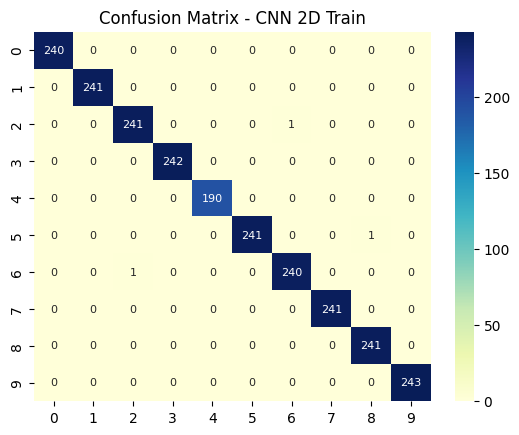

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


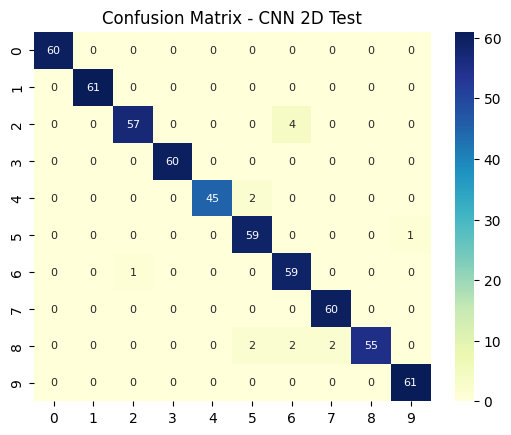

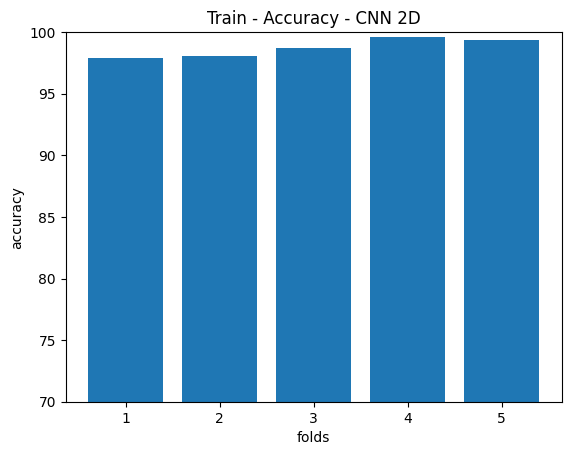

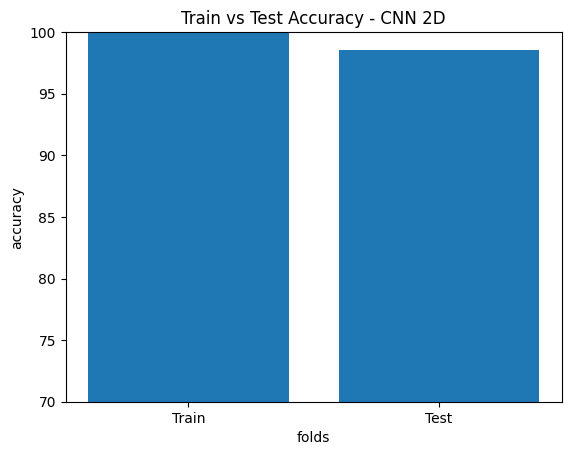

In [12]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()